In [11]:
import numpy as np

In [12]:
sequences = np.load('childes_test_seqs.npy', allow_pickle=True)

In [13]:
import matplotlib.pyplot as plt

In [14]:
print(' '.join(sequences[0][:200]))

more cookie more cookie more juice Fraser Fraser Fraser Fraser yeah  a fly fly Mommy telephone my telephone Mommy no man man more cookie block broke there I did it there there Fraser baby Mommy read a stool Fraser Fraser more cookie more cookie little little little little milk milk milk milk that Fraser water oh Fraser bye water Fraser water Fraser water that coffee Fraser coffee down down cookie Mommy Mommy a fly read the puzzle read the puzzle read the puzzle read the puzzle read the puzzle read the puzzle read the puzzle Racketyboom hat m water bottle water there Fraser hat oh Fraser hat oh Fraser hat oh Fraser hat Fraser hat no eye that that soldier soldier that that Fraser hat Eve find it that that man Eve down that busy busy man a pencil man a pencil man pencil Eve pencil Eve pencil Eve pencil man a pencil pencil man see ya read read Clip_clop shoe shoe shoe shoe shoe shoe shoe my my my my Mommy book Racketyboom Racketyboom Racketyboom Racketyboom read Racketyboom Racketyboom Rac

(array([153.,  17.,   2.,   5.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([   0. ,  131.8,  263.6,  395.4,  527.2,  659. ,  790.8,  922.6,
        1054.4, 1186.2, 1318. ]),
 <a list of 10 Patch objects>)

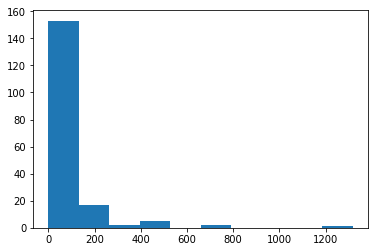

In [15]:
plt.hist([len(i) for i in sequences])

In [16]:
from sklearn.metrics.cluster.supervised import contingency_matrix
import numpy as np
from sklearn.metrics import (
    mutual_info_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
)
from childes_mi.information_theory.expected_mutual_information import emi_parallel
#from .emi._expected_mutual_info_fast import expected_mutual_information
from childes_mi.information_theory.emi._expected_mutual_info_fast_sklearn import expected_mutual_information




def adjusted_mutual_information(labels_true, labels_pred, n_jobs = -1, emi_method="parallel", use_cython=True,
                               average_method='arithmetic'):
    """Adjusted Mutual Information.
    Adjusted Mutual Information (AMI) is an adjustment of the Mutual
    Information (MI) score to account for chance. It accounts for the fact that
    the MI is generally higher for two clusterings with a larger number of
    clusters, regardless of whether there is actually more information shared.
    For two clusterings :math:`U` and :math:`V`, the AMI is given as::
        AMI(U, V) = [MI(U, V) - E(MI(U, V))] / [avg(H(U), H(V)) - E(MI(U, V))]
    
    """
    n_samples = labels_true.shape[0]
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    # Special limit cases: no clustering since the data is not split.
    # This is a perfect match hence return 1.0.
    if (classes.shape[0] == clusters.shape[0] == 1 or
            classes.shape[0] == clusters.shape[0] == 0):
        return 1.0
    contingency = contingency_matrix(labels_true, labels_pred, sparse=True)
    contingency = contingency.astype(np.float64,
                                     **_astype_copy_false(contingency))
    # Calculate the MI for the two clusterings
    mi = mutual_info_score(labels_true, labels_pred,
                           contingency=contingency)
    # Calculate the expected value for the mutual information
    if emi_method == "parallel":
        emi = emi_parallel(contingency, n_samples, use_cython = use_cython, n_jobs=n_jobs)
    else:
        emi = expected_mutual_information(contingency, n_samples)
    # Calculate entropy for each labeling
    h_true, h_pred = entropy(labels_true), entropy(labels_pred)
    normalizer = _generalized_average(h_true, h_pred, average_method)
    denominator = normalizer - emi
    # Avoid 0.0 / 0.0 when expectation equals maximum, i.e a perfect match.
    # normalizer should always be >= emi, but because of floating-point
    # representation, sometimes emi is slightly larger. Correct this
    # by preserving the sign.
    if denominator < 0:
        denominator = min(denominator, -np.finfo('float64').eps)
    else:
        denominator = max(denominator, np.finfo('float64').eps)
    ami = (mi - emi) / denominator
    return ami, emi


def entropy(labels):
    """Calculates the entropy for a labeling.
    Parameters
    ----------
    labels : int array, shape = [n_samples]
        The labels
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))

def _generalized_average(U, V, average_method="arithmetic"):
    """Return a particular mean of two numbers."""
    if average_method == "min":
        return min(U, V)
    elif average_method == "geometric":
        return np.sqrt(U * V)
    elif average_method == "arithmetic":
        return np.mean([U, V])
    elif average_method == "max":
        return max(U, V)
    else:
        raise ValueError("'average_method' must be 'min', 'geometric', "
                         "'arithmetic', or 'max'")


def _parse_version(version_string):
    version = []
    for x in version_string.split('.'):
        try:
            version.append(int(x))
        except ValueError:
            # x may be of the form dev-1ea1592
            version.append(x)
    return tuple(version)

import scipy
sp_version = _parse_version(scipy.__version__)

def _astype_copy_false(X):
    """Returns the copy=False parameter for
    {ndarray, csr_matrix, csc_matrix}.astype when possible,
    otherwise don't specify
    """
    if sp_version >= (1, 1) or not sp.issparse(X):
        return {'copy': False}
    else:
        return {}

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [17]:
# make a unique contingency matrix for each sequence

In [55]:
def MI_from_distributions(
    sequences,
    dist,
    estimate=False,
    unclustered_element=None,
    use_sklearn=True,
    n_jobs = -1,
    mi_estimation = "grassberger", # "adjusted_mi", None
    shuffle=False,
    **mi_kwargs
):
    
    
    np.random.seed()  # set seed
    # create distributions
    if np.sum([len(seq) > dist for seq in sequences]) == 0:
        return (np.nan, np.nan)

    
    
    if shuffle:
        distribution_a = np.concatenate(
            [np.random.permutation(seq[dist:]) for seq in sequences if len(seq) > dist]
        )

        distribution_b = np.concatenate(
            [np.random.permutation(seq[:-dist]) for seq in sequences if len(seq) > dist]
        )
    
    else:
        distribution_a = np.concatenate(
            [seq[dist:] for seq in sequences if len(seq) > dist]
        )

        distribution_b = np.concatenate(
            [seq[:-dist] for seq in sequences if len(seq) > dist]
        )
        
        
    # mask unclustered so they are not considered in MI
    if unclustered_element is not None:
        mask = (distribution_a == unclustered_element) | (
            distribution_b == unclustered_element
        )
        distribution_a = distribution_a[mask == False]
        distribution_b = distribution_b[mask == False]

    # calculate MI

    if mi_estimation == "grassberger":
        # See Grassberger, P. Entropy estimates from insufficient samplings. arXiv 2003, arXiv:0307138
        return est_mutual_info_p(distribution_a, distribution_b, **mi_kwargs)
    elif mi_estimation == "adjusted_mi":
        # See Vinh, Epps, and Bailey, (2010). Information Theoretic Measures for Clusterings Comparison: Variants, Properties, Normalization and Correction for Chance, JMLR
        return adjusted_mutual_information(distribution_a, distribution_b, n_jobs=n_jobs, **mi_kwargs)
    elif mi_estimation == "adjusted_mi_sklearn":
        # See Vinh, Epps, and Bailey, (2010). Information Theoretic Measures for Clusterings Comparison: Variants, Properties, Normalization and Correction for Chance, JMLR
        #return (adjusted_mutual_info_score(distribution_a, distribution_b), 0)
        return adjusted_mutual_information(distribution_a, distribution_b, emi_method="sklearn", **mi_kwargs)
    elif mi_estimation is None:
        return (mutual_info_score(distribution_a, distribution_b, **mi_kwargs), 0)
    else:
        raise ValueError("MI estimator '{}' is not implemented".format(mi_estimation))


In [56]:
def sequential_mutual_information(
    sequences,
    distances,
    n_jobs=1,
    verbosity=5,
    n_shuff_repeats=1,
    estimate=True,
    disable_tqdm=False,
    prefer="threads",  # is None better here?
    mi_estimation = "grassberger",
    unclustered_element=None,
    **mi_kwargs
):
    """
    Compute mutual information as a function of distance between sequences
    if n_jobs > 1,  will run in parallel
    """
    # convert to numeric for faster computation
    unique_elements = np.unique(np.concatenate(sequences))
    n_unique = len(unique_elements)
    seq_dict = {j: i for i, j in enumerate(unique_elements)}
    if n_unique < 256:
        sequences = [
            np.array([seq_dict[i] for i in seq]).astype("uint8") for seq in sequences
        ]
    elif n_unique < 65535:
        sequences = [
            np.array([seq_dict[i] for i in seq]).astype("uint16") for seq in sequences
        ]
    else:
        sequences = [
            np.array([seq_dict[i] for i in seq]).astype("uint32") for seq in sequences
        ]

    if unclustered_element is not None:
        unclustered_element = seq_dict[unclustered_element]
        print(unclustered_element)
    else:
        unclustered_element = None


    if mi_estimation == "adjusted_mi":
        # because parallelization occurs within the function
        _n_jobs = copy.deepcopy(n_jobs)
        n_jobs = 1
    else:
        _n_jobs = 1
    # compute MI
    if n_jobs == 1:
        MI = [
            MI_from_distributions(
                sequences,
                dist,
                estimate=estimate,
                unclustered_element=unclustered_element,
                mi_estimation=mi_estimation,
                **mi_kwargs
            )
            for dist_i, dist in enumerate(
                tqdm(distances, leave=False, disable=disable_tqdm)
            )
        ]
        distances_rep = np.repeat(distances, n_shuff_repeats)
        shuff_MI = [
            MI_from_distributions(
                [np.random.permutation(i) for i in sequences],
                dist,
                estimate=estimate,
                mi_estimation=mi_estimation,
                **mi_kwargs
            )
            for dist_i, dist in enumerate(
                tqdm(distances_rep, leave=False, disable=disable_tqdm)
            )
        ]

        shuff_MI = np.reshape(shuff_MI, (len(distances), n_shuff_repeats, 2))
        shuff_MI = np.mean(shuff_MI, axis=1)

    else:
        with Parallel(n_jobs=n_jobs, verbose=verbosity, prefer=prefer) as parallel:
            MI = parallel(
                delayed(MI_from_distributions)(
                    sequences,
                    dist,
                    estimate=estimate,
                    unclustered_element=unclustered_element,
                    n_jobs = _n_jobs,
                    mi_estimation=mi_estimation,
                    **mi_kwargs
                )
                for dist_i, dist in enumerate(
                    tqdm(distances, leave=False, disable=disable_tqdm)
                )
            )

        with Parallel(n_jobs=n_jobs, verbose=verbosity, prefer=prefer) as parallel:
            distances_rep = np.repeat(distances, n_shuff_repeats)
            shuff_MI = parallel(
                delayed(MI_from_distributions)(
                    sequences,#[np.random.permutation(i) for i in sequences],
                    dist,
                    estimate=estimate,
                    unclustered_element=unclustered_element,
                    n_jobs = _n_jobs,
                    shuffle=True,
                    mi_estimation=mi_estimation,
                    **mi_kwargs
                )
                for dist_i, dist in enumerate(
                    tqdm(distances_rep, leave=False, disable=disable_tqdm)
                )
            )
            shuff_MI = np.reshape(shuff_MI, (len(distances), n_shuff_repeats, 2))
            shuff_MI = np.mean(shuff_MI, axis=1)

    return np.array(MI).T, np.array(shuff_MI).T

In [61]:
distances= np.unique(np.logspace(0,12, base=2, num = 10000).astype('int'))
print(distances, len(distances))
mi_estimation = None

[   1    2    3 ... 4089 4092 4096] 2675


In [62]:
from joblib import Parallel, delayed, parallel_backend
from tqdm.autonotebook import tqdm

In [63]:
with parallel_backend('multiprocessing'):

    (MI, MI_var), (shuff_MI, shuff_MI_var) = sequential_mutual_information(
            sequences, distances=distances, n_jobs=-1, mi_estimation=mi_estimation, prefer = None, verbosity=5
    ) 

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2675 out of 2675 | elapsed:    1.9s finished


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2675 out of 2675 | elapsed:    1.4s finished


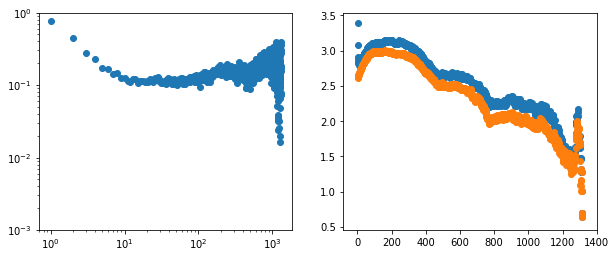

In [66]:
fig,axs = plt.subplots(ncols=2, figsize = (10,4))
ax = axs[0]
ax.scatter(distances, MI-shuff_MI)
ax.plot(distances, MI-shuff_MI, alpha = 0)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-3,1])

ax = axs[1]
ax.scatter(distances, MI)
ax.scatter(distances, shuff_MI)
#ax.set_ylim([0,0.25])
plt.show()